# Fraud framework - Model building

The financial service industry (FSI) is rushing towards transformational change to support new channels and services, delivering transactional features and facilitating payments through new digital channels to remain competitive. Unfortunately, the speed and convenience that these capabilities afford is a benefit to consumers and fraudsters alike.

Building a fraud framework often goes beyond just creating a highly accurate machine learning model due ever changing landscape and customer expectation. Oftentimes it involves a complex decision science setup which combines rules engine with a need for a robust and scalable machine learning platform. 

In [1]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
import xgboost as xgb                # gradient boosting machines (GBMs)
import mlflow
import os
import mlflow.pyfunc
import mlflow.spark
import mlflow
from mlflow.tracking import MlflowClient
 
mlflow.set_tracking_uri("http://host.docker.internal:5000")
client = MlflowClient("http://host.docker.internal:5000")

In [2]:
from pyspark import SparkFiles
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('Fraud Detection').getOrCreate()
raw_data_path = 'Fraud_final-1.parquet'

In [3]:
url = "https://raw.githubusercontent.com/databricks-industry-solutions/fraud-orchestration/main/Fraud_final-1.csv"
spark.sparkContext.addFile(url)
spark.read.option("inferSchema", "true") \
          .option("header", "true") \
          .option("delim", ",") \
          .csv("file://" + SparkFiles.get("Fraud_final-1.csv")) \
          .write \
          .format("parquet") \
          .mode("overwrite") \
          .save(raw_data_path)

In [4]:
def preprocess_data(source_df,
                    numeric_columns,
                    fitted_scaler):
    '''
    Subset df with selected columns
    Use the fitted scaler to center and scale the numeric columns  
    '''
    res_df = source_df[numeric_columns].copy()

    ## scale the numeric columns with the pre-built scaler
    res_df[numeric_columns] = fitted_scaler.transform(res_df[numeric_columns])

    return res_df

In [5]:
class XGBWrapper(mlflow.pyfunc.PythonModel):
    '''
    XGBClassifier model with embedded pre-processing.

    This class is an MLflow custom python function wrapper around a XGB model.
    The wrapper provides data preprocessing so that the model can be applied to input dataframe directly.
    :Input: to the model is pandas dataframe
    :Output: predicted price for each listing
    The model declares current local versions of XGBoost and pillow as dependencies in its
    conda environment file.  
    '''
    def __init__(self,
               model,
               X,
               y,
               numeric_columns):

        self.model = model

        from sklearn.model_selection import train_test_split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.30, random_state=2019)
        self.numeric_columns = numeric_columns

        from sklearn.preprocessing import StandardScaler 
        #create a scaler for our numeric variables
        # only run this on the training dataset and use to scale test set later.
        scaler = StandardScaler()
        self.fitted_scaler = scaler.fit(self.X_train[self.numeric_columns])
        self.X_train_processed = preprocess_data(self.X_train, self.numeric_columns, self.fitted_scaler)
        self.X_test_processed  = preprocess_data(self.X_test, self.numeric_columns, self.fitted_scaler)

        def _accuracy_metrics(model, X, y):
            import sklearn
            from sklearn import metrics
            y_pred = model.predict_proba(X)[:,1]
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, y_pred)
            self.auc = sklearn.metrics.auc(fpr, tpr)
            print("Model AUC is:", self.auc)

            return self.auc

        self.auc = _accuracy_metrics(model=self.model, X=self.X_test_processed, y=self.y_test )


    def predict(self, context, input):
        '''
          Generate predictions from the input df 
          Subset input df with selected columns
          Assess the model accuracy
          Use the fitted scaler to center and scale the numeric columns  
          :param input: pandas.DataFrame with numeric_columns to be scored. The
                       columns must has same schema as numeric_columns of X_train
         :return: numpy 1-d array as fraud probabilities 
        '''
        input_processed = self._preprocess_data(X=input, numeric_columns=self.numeric_columns, fitted_scaler=self.fitted_scaler )
        return pd.DataFrame(self.model.predict_proba(input_processed)[:,1], columns=['predicted'])


    def _preprocess_data(self,
                      X,
                      numeric_columns,
                      fitted_scaler):
        res_df = preprocess_data(X, numeric_columns, fitted_scaler)
        self._df = res_df

        return res_df

In [6]:
def fit(X, y):
    """
    :return: dict with fields 'loss' (scalar loss) and 'model' fitted model instance
    """
    import xgboost
    from xgboost import XGBClassifier
    from sklearn.model_selection import cross_val_score

    _model =  XGBClassifier(learning_rate=0.3,
                          gamma=5,
                          max_depth=8,
                          n_estimators=15,
                          min_child_weight = 9, objective='binary:logistic')

    xgb_model = _model.fit(X, y)

    score = -cross_val_score(_model, X, y, scoring='roc_auc').mean()

    return {'loss': score, 'model': xgb_model}

In [7]:
from pyspark.sql.functions import * 

import cloudpickle
import pandas as pd
import numpy as np

Our input dataset has several fields which will be used for rule based modeling and machine learning. In this notebook we will rely on our machine learning model to identify important features that are effective at predicting fraud. Let's take a look into descriptions of these features to understand our downstream modeling and intrepretability results.


- LAST_ADR_CHNG_DUR     - Duration in days since the last address change on the account.
- AVG_DLY_AUTHZN_AMT    - The average daily authorization amount on the plastic since the day of first use.
- DISTANCE_FROM_HOME	  - Approximate distance of customer's home from merchant.
- HOME_PHN_NUM_CHNG_DUR - Duration in days since the home phone number was changed on the account.

In [8]:
df = spark.read.format("parquet") \
  .load(raw_data_path)

data = df.toPandas()
data = data.drop(columns=['AUTH_ID', 'ACCT_ID_TOKEN'])
numeric_columns = data.columns.to_list()
numeric_columns.remove('FRD_IND')
data.head()

,ACCT_PROD_CD,ACCT_AVL_CASH_BEFORE_AMT,ACCT_AVL_MONEY_BEFORE_AMT,ACCT_CL_AMT,ACCT_CURR_BAL,APPRD_AUTHZN_CNT,APPRD_CASH_AUTHZN_CNT,AUTHZN_AMT,AUTHZN_OUTSTD_AMT,AVG_DLY_AUTHZN_AMT,AUTHZN_OUTSTD_CASH_AMT,CDHLDR_PRES_CD,HOTEL_STAY_CAR_RENTL_DUR,LAST_ADR_CHNG_DUR,HOME_PHN_NUM_CHNG_DUR,PLSTC_ISU_DUR,POS_COND_CD,POS_ENTRY_MTHD_CD,DISTANCE_FROM_HOME,FRD_IND
0,10.0,11500.0,20153.38,23000,2647.55,2,0,10.33,209.40,51,0.0,0.0,0,779,0,18,0,90,10.486238,0
1,12.0,2500.0,2639.33,5000,2200.72,3,0,12.44,172.39,22,0.0,0.0,0,999,577,781,0,90,0.000000,0
2,12.0,2500.0,4697.33,5000,302.67,1,0,5.27,5.27,4,0.0,0.0,0,999,0,999,0,90,0.690797,0
3,12.0,15000.0,29898.62,30000,101.38,0,0,13.00,0.00,0,0.0,3.0,0,294,0,181,8,1,0.000000,0
4,21.0,300.0,300.00,300,0.00,0,0,18.27,0.00,0,0.0,2.0,0,0,0,110,8,1,1.541868,0


In [9]:
conda_env = mlflow.pyfunc.get_default_conda_env()
conda_env['dependencies'][2]['pip'] += ['xgboost']
conda_env['dependencies'][2]['pip'] += ['sklearn']

/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [10]:
experiment_name = f"/dff_orchestrator"
mlflow.set_experiment(experiment_name) 
model_run_name = 'fraud-xgb-wrapper'

In [11]:
with mlflow.start_run() as run:
    mlflow.log_param('Input-data-location', raw_data_path)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(["FRD_IND"], axis=1), data["FRD_IND"], test_size=0.33, random_state=42)

    from sklearn.preprocessing import StandardScaler 
    # create a scaler for our numeric variables
    # only run this on the training dataset and use to scale test set later.
    scaler = StandardScaler()
    fitted_scaler = scaler.fit(X_train[numeric_columns])
    X_train_processed = preprocess_data(source_df=X_train, numeric_columns=numeric_columns, fitted_scaler=fitted_scaler )

    #train a model and get the loss
    train_dict = {}
    train_dict = fit(X=X_train_processed, y=y_train)
    xgb_model = train_dict['model']
    mlflow.log_metric('loss', train_dict['loss'])

    ##------- log pyfunc custom model -------##
    # make an instance of the Pyfunc Class
    myXGB = XGBWrapper(model = xgb_model,
                     X = data[numeric_columns].copy(), 
                     y = data['FRD_IND'], 
                     numeric_columns = numeric_columns)

    mlflow.pyfunc.log_model(model_run_name, python_model=myXGB, conda_env=conda_env)

    mlflow.log_metric('auroc', myXGB.auc)
  
# programmatically get the latest Run ID
runs = mlflow.search_runs(mlflow.get_experiment_by_name(experiment_name).experiment_id)
latest_run_id = runs.sort_values('end_time').iloc[-1]["run_id"]
print('The latest run id: ', latest_run_id)

Model AUC is: 0.9698514579130754
The latest run id:  22dbc55b21a04e96a32d1db94d2f1672


In [12]:
X = data[numeric_columns].copy()
y = data['FRD_IND']
train_dict = fit(X=X, y=y)
xgb_model = train_dict['model']

predictions = myXGB.predict(spark, X)
predictions.tail()

,predicted
1899,0.753315
1900,0.641191
1901,0.598438
1902,0.753315
1903,0.494439


In [13]:
model_uri = "runs:/{}/{}".format(latest_run_id, model_run_name)
model_name = "fraud_xgb_model"
result = mlflow.register_model(model_uri, model_name)
version = result.version

Registered model 'fraud_xgb_model' already exists. Creating a new version of this model...
2022/12/14 05:57:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: fraud_xgb_model, version 2
Created version '2' of model 'fraud_xgb_model'.


In [14]:
client.transition_model_version_stage(
  name=model_name,
  version=version,
  stage="Production",
)

<ModelVersion: creation_timestamp=1670997431510, current_stage='Production', description='', last_updated_timestamp=1670997431678, name='fraud_xgb_model', run_id='22dbc55b21a04e96a32d1db94d2f1672', run_link='', source='mlflow-artifacts:/1/22dbc55b21a04e96a32d1db94d2f1672/artifacts/fraud-xgb-wrapper', status='READY', status_message='', tags={}, user_id='', version='2'>

In [15]:
import shap
from pyspark.sql import *
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X, y=y.values)
mean_abs_shap = np.absolute(shap_values).mean(axis=0).tolist()
spark.createDataFrame(sorted(list(zip(mean_abs_shap, X.columns)), reverse=True)[:8], ["Mean |SHAP|", "Column"]).show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


+-------------------+--------------------+
|        Mean |SHAP||              Column|
+-------------------+--------------------+
| 0.4465157985687256|   AUTHZN_OUTSTD_AMT|
|0.43674156069755554|  AVG_DLY_AUTHZN_AMT|
|0.43153446912765503|          AUTHZN_AMT|
|0.38638320565223694|   LAST_ADR_CHNG_DUR|
|0.32470762729644775|       PLSTC_ISU_DUR|
| 0.3182542622089386|        ACCT_PROD_CD|
| 0.2876538336277008|HOME_PHN_NUM_CHNG...|
|0.25261637568473816|       ACCT_CURR_BAL|
+-------------------+--------------------+



In [16]:
shap_values = explainer.shap_values(X, y=y.values)
print(shap_values.shape)

(1904, 19)


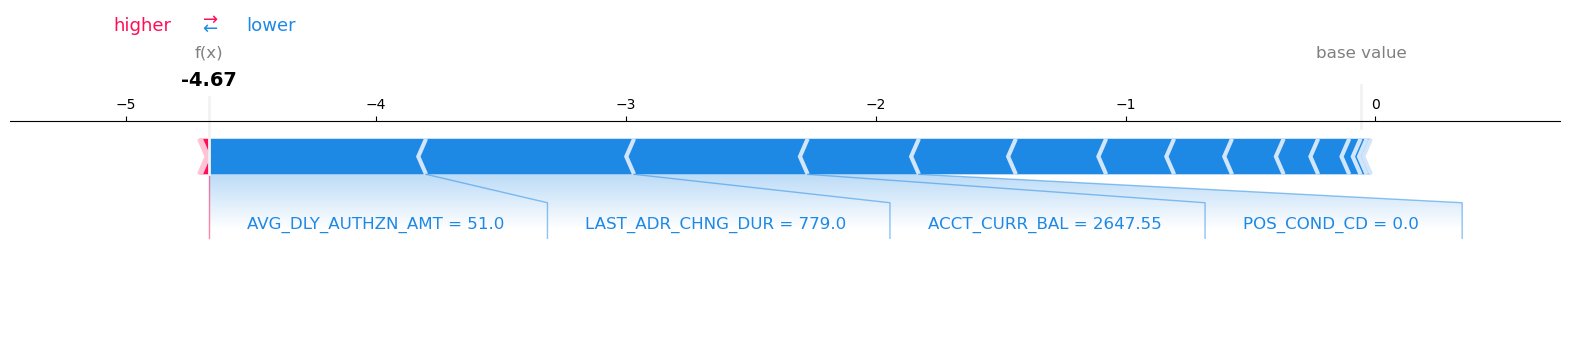

In [17]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:],matplotlib=True)

In [18]:
import pandas as pd 
schema = spark.createDataFrame(X).schema
df = spark.createDataFrame(pd.DataFrame(shap_values, columns=X.columns)).withColumn("id", monotonically_increasing_id())
for col in df.columns:
    df = df.withColumnRenamed(col, 'shap_v_' + col)
df.createOrReplaceTempView("fraud_shap_values")

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [19]:
spark.createDataFrame(pd.concat([pd.DataFrame(X, columns=X.columns), pd.DataFrame(predictions, columns=['predicted']), pd.DataFrame(y, columns=['FRD_IND'])], axis=1)).withColumn("id", monotonically_increasing_id()).createOrReplaceTempView("txns")


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [20]:
spark.sql("""select t.*, 
       s.*
from txns t join fraud_shap_values s 
on t.id = s.shap_v_id""").write.format("parquet").mode('overwrite').save("silver_fraud_shap_values.parquet")

In [21]:
df = spark.read.format("parquet") \
  .load("silver_fraud_shap_values.parquet").createOrReplaceTempView("silver_fraud_shap_values")
spark.sql("""select case when predicted > 0.5 then 1 else 0 end predicted_Ind, frd_ind, count(1) ct
from silver_fraud_shap_values
group by case when predicted > 0.5 then 1 else 0 end, frd_ind""").show()

+-------------+-------+---+
|predicted_Ind|frd_ind| ct|
+-------------+-------+---+
|            1|      0| 17|
|            0|      0|935|
|            0|      1|421|
|            1|      1|531|
+-------------+-------+---+



In [51]:
import ipywidgets as widgets
from ipywidgets import Layout, Button
style = {'description_width': 'initial'}
def int_text(text, value):
    
    return widgets.IntText(
        layout=Layout(flex='1 1 auto', width='50%'),
        style=style,
        value=value,
        description=text
    )




from ipywidgets import GridspecLayout

grid = GridspecLayout((len(numeric_columns)//2) + 3, 2)

def load_grid():
    fields = data[numeric_columns].to_dict('split')
    rnd = np.random.randint(0,len(fields['data']))
    fields = list(zip(fields['columns'],fields['data'][rnd]))
    for i in range(len(numeric_columns)//2 +1):
        for j in range(2):
            if i*2+j%4 < len(numeric_columns):
                grid[i, j] = int_text(*fields[i*2+j%4])
    return fields
                
fields = load_grid()

grid[len(numeric_columns)//2+1, 0] = widgets.Button(
    description='Predict',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Predict'
)
grid[len(numeric_columns)//2+1, 1] = widgets.Button(
    description='Refresh',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Refresh'
)
def predict():
    datamap = {}
    for i in range(len(numeric_columns)//2 +1):
        for j in range(2):
            if i*2+j%4 < len(numeric_columns):
                datamap[fields[i*2+j%4][0]] = [grid[i, j].value]
    
    df = pd.DataFrame.from_dict(datamap)

    logged_model = 'runs:/e402fa9ca7d04e3e835358324aee8ce8/fraud-xgb-wrapper'

    # Score dataframe against DFF orchestration engine
    model = mlflow.pyfunc.load_model(logged_model)
    decision = 0 #model.predict(df).iloc[0]
    grid[len(numeric_columns)//2+2 , 1]= widgets.IntText(
        layout=Layout(flex='1 1 auto', width='50%'),
        style=style,
        value=decision,
        description='FRD_IND',
        disabled=True
    )
    
#
def on_button_clicked(b):
    predict()

def on_button_refresh(b):
    load_grid()
    
grid[len(numeric_columns)//2+1 , 0].on_click(on_button_clicked)
grid[len(numeric_columns)//2+1 , 1].on_click(on_button_refresh)
grid


GridspecLayout(children=(IntText(value=21, description='ACCT_PROD_CD', layout=Layout(flex='1 1 auto', grid_are…

In [23]:
!rm -rf Fraud_final-1*
!rm -rf silver_fraud*